In [152]:
#import packages 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from tobler.util import h3fy #hexgrid creation and data interpolation 
from tobler.area_weighted import area_interpolate #spatial interpolation
import contextily as ctx #add base maps
from matplotlib_scalebar.scalebar import ScaleBar 

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

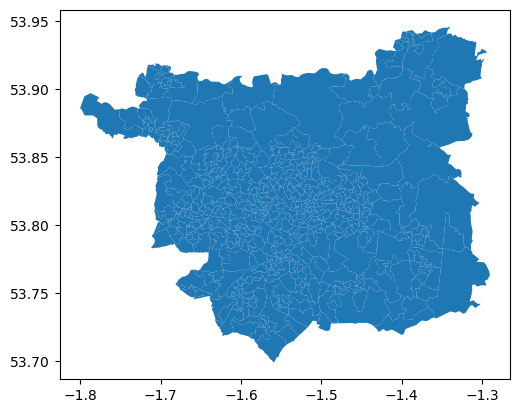

In [183]:
lsoa = gpd.read_file('Lower_Super_Output_Area_(LSOA)_IMD2019__(WGS84).geojson')
leeds_lsoa = lsoa[lsoa["lsoa11nm"].str.contains("Leeds")]

leeds_lsoa.plot()
leeds_lsoa.crs

<Axes: >

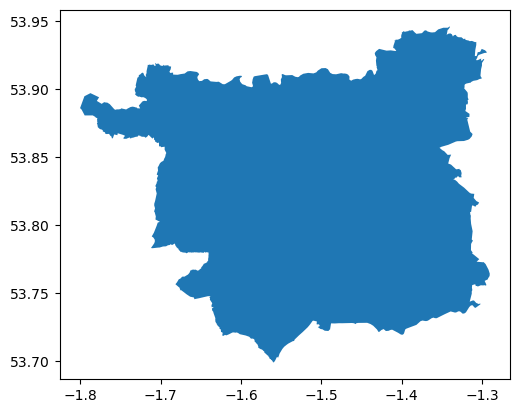

In [154]:
leeds_bound = leeds_lsoa
leeds_bound['temp'] = 1
leeds_bound = leeds_bound.dissolve(by='temp')
leeds_bound.plot()

In [155]:
bua = gpd.read_file('BUA_2022_GB_-8042218937152150708.geojson')
bua = bua.to_crs(4326)

<Axes: >

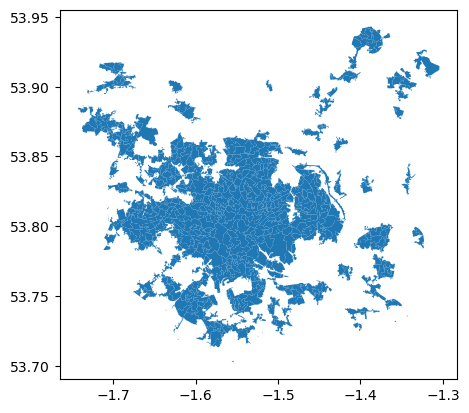

In [156]:
leeds_bua = gpd.clip(bua, leeds_bound)
leeds_bua = gpd.clip(leeds_lsoa, leeds_bua)
leeds_bua.plot()

### Load age group data 

In [187]:
age = pd.read_csv("census2021-ts007a-lsoa.csv")
age['pop_under19'] = age['Age: Aged 4 years and under']+age['Age: Aged 5 to 9 years']+age['Age: Aged 10 to 14 years']+age['Age: Aged 15 to 19 years']

age = age[['date','geography','geography code','Age: Total','pop_under19']]
age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            35672 non-null  int64 
 1   geography       35672 non-null  object
 2   geography code  35672 non-null  object
 3   Age: Total      35672 non-null  int64 
 4   pop_under19     35672 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.4+ MB


In [158]:
age_merge = age[['geography code','Age: Total','pop_under19']]

leeds_bua = pd.merge(leeds_bua, age_merge, left_on='lsoa11cd', right_on= 'geography code', how='left')
leeds_bua.head()

FID   lsoa11cd    lsoa11nm  IMDRank  IMDDecil   Shape__Area  \
0  12186  E01011536  Leeds 108B    21246         7  1.000293e+07   
1  12187  E01011537  Leeds 107A    15493         5  4.305344e+06   
2  12198  E01011552  Leeds 107D     4739         2  1.097999e+06   
3  12188  E01011538  Leeds 107B     5898         2  8.130981e+06   
4  12150  E01011497  Leeds 101E     1689         1  1.277048e+06   

   Shape__Length                                           geometry  temp  \
0   18047.806059  MULTIPOLYGON (((-1.55396 53.70242, -1.55503 53...     1   
1   10316.102374  MULTIPOLYGON (((-1.53939 53.72592, -1.53805 53...     1   
2    6892.198504  POLYGON ((-1.55739 53.72716, -1.55647 53.72844...     1   
3   17489.550640  MULTIPOLYGON (((-1.55532 53.73743, -1.55464 53...     1   
4    8761.169192  MULTIPOLYGON (((-1.55025 53.74775, -1.54967 53...     1   

  geography code  Age: Total  pop_under19  
0      E01011536      1653.0        359.0  
1      E01011537      2045.0        362.0  
2      E01011552      1521.0        440.0  
3      E01011538      1588.0        365.0  
4      E01011497      1727.0        594.0

### Food charities and food type

In [159]:
charity_all = pd.read_csv('Dispatch Metrics_Children_all.csv')
charity_all.head()

Nature of Organisation    Beneficiary Group  \
0                 School  Children (Under 18)   
1                 School  Children (Under 18)   
2                 School  Children (Under 18)   
3                 School  Children (Under 18)   
4                 School  Children (Under 18)   

                           Charity  Food Moved KG  \
0  Allerton Bywater Primary School       4845.830   
1  Allerton Bywater Primary School       4634.860   
2  Allerton Bywater Primary School       1835.200   
3          Allerton C of E Primary       4900.130   
4          Allerton C of E Primary       4985.252   

   Food Moved Meal Equivalents  CFMs Served  CFM Beneficiaries Value of food  \
0                  11537.92123          1.0              115.0     16,558.16   
1                  11035.60166          1.0              115.0     17,804.69   
2                   4369.61120          1.0              115.0      6,295.28   
3                  11667.20953          1.0              115.0     18,516.42   
4                  11869.88501          1.0              115.0     17,464.50   

     Year      long        lat  
0  2022.0 -1.370255  53.747328  
1  2023.0 -1.370255  53.747328  
2  2024.0 -1.370255  53.747328  
3  2022.0 -1.545439  53.852317  
4  2023.0 -1.545439  53.852317

In [160]:
# only include food moved in 2023
charity_all_2023 = charity_all[charity_all.Year == 2024]
charity_all_2023

Nature of Organisation    Beneficiary Group  \
2                  School  Children (Under 18)   
5                  School  Children (Under 18)   
8       Food service only  Children (Under 18)   
13       Community centre  Children (Under 18)   
14       Community centre  Children (Under 18)   
21                    NaN  Children (Under 18)   
26                 School  Children (Under 18)   
29       Community centre  Children (Under 18)   
33                 School  Children (Under 18)   
37        Training centre  Children (Under 18)   
38        Training centre  Children (Under 18)   
41                 School  Children (Under 18)   
44       Community centre  Children (Under 18)   
48      Food service only  Children (Under 18)   
49      Food service only  Children (Under 18)   
53                 School  Children (Under 18)   
56     Out of school club  Children (Under 18)   

                             Charity  Food Moved KG  \
2    Allerton Bywater Primary School       1835.200   
5            Allerton C of E Primary       2200.960   
8      Catch/Ark Community Cafe (HH)        193.500   
13                    CFYDC (Chance)       2344.200   
14                    CFYDC (Chance)        833.000   
21                           DAZL HH        760.900   
26  Guiseley Community Foundation HH        488.900   
29                   Hunslet Club HH        265.500   
33            Leeds Mencap (Jimbo's)       2240.220   
37             NACRO College (Leeds)       2813.760   
38             NACRO College (Leeds)        868.882   
41     Reach Primary Learning Centre       2079.820   
44                  Reestablish (HH)        199.700   
48                      Rethink Food      34376.380   
49                      Rethink Food       4871.750   
53    St Peter s CoE Primary (Leeds)        418.100   
56                    Stitch-up (HH)        291.000   

    Food Moved Meal Equivalents  CFMs Served  CFM Beneficiaries Value of food  \
2                   4369.611200          1.0              115.0      6,295.28   
5                   5240.485760          1.0              115.0      8,059.38   
8                    460.723500          1.0              115.0        599.48   
13                  5581.540200          1.0              115.0      9,834.87   
14                  1983.373000          1.0              115.0      2,521.88   
21                  1811.702900          1.0              115.0      3,286.20   
26                  1164.070900          1.0              115.0        935.69   
29                   632.155500          1.0              115.0      1,098.84   
33                  5333.963820          1.0              115.0      8,232.85   
37                  6699.562560          1.0              115.0     11,380.17   
38                  2068.808042          1.0              115.0      3,681.40   
41                  4952.051420          1.0              115.0      7,375.47   
44                   475.485700          1.0              115.0        699.58   
48                 81850.160780          1.0              115.0    106,137.47   
49                 11599.636750          1.0              115.0     19,641.96   
53                   995.496100          1.0              115.0      1,268.59   
56                   692.871000          1.0              115.0        891.37   

      Year      long        lat  
2   2024.0 -1.370255  53.747328  
5   2024.0 -1.545439  53.852317  
8   2024.0 -1.511364  53.816355  
13  2024.0 -1.542289  53.818422  
14  2024.0 -1.542422  53.817986  
21  2024.0 -1.550256  53.744015  
26  2024.0 -1.704426  53.875803  
29  2024.0 -1.535015  53.779983  
33  2024.0 -1.512217  53.797038  
37  2024.0 -1.548859  53.817823  
38  2024.0 -1.548859  53.817823  
41  2024.0 -1.545512  53.781934  
44  2024.0 -1.557853  53.777435  
48  2024.0 -1.569785  53.781399  
49  2024.0 -1.569785  53.781399  
53  2024.0 -1.530051  53.800774  
56  2024.0 -1.562619  53.828127

In [161]:
#creat a geodataframe for charities
from shapely.geometry import Point
charity_all_2023['Coordinates'] = list(zip(charity_all_2023.long, charity_all_2023.lat))
charity_all_2023['Coordinates'] = charity_all_2023['Coordinates'].apply(Point)
charity_all_2023 = gpd.GeoDataFrame(charity_all_2023, geometry='Coordinates')
charity_all_2023.head()


Nature of Organisation    Beneficiary Group  \
2                  School  Children (Under 18)   
5                  School  Children (Under 18)   
8       Food service only  Children (Under 18)   
13       Community centre  Children (Under 18)   
14       Community centre  Children (Under 18)   

                            Charity  Food Moved KG  \
2   Allerton Bywater Primary School        1835.20   
5           Allerton C of E Primary        2200.96   
8     Catch/Ark Community Cafe (HH)         193.50   
13                   CFYDC (Chance)        2344.20   
14                   CFYDC (Chance)         833.00   

    Food Moved Meal Equivalents  CFMs Served  CFM Beneficiaries Value of food  \
2                    4369.61120          1.0              115.0      6,295.28   
5                    5240.48576          1.0              115.0      8,059.38   
8                     460.72350          1.0              115.0        599.48   
13                   5581.54020          1.0              115.0      9,834.87   
14                   1983.37300          1.0              115.0      2,521.88   

      Year      long        lat                Coordinates  
2   2024.0 -1.370255  53.747328  POINT (-1.37026 53.74733)  
5   2024.0 -1.545439  53.852317  POINT (-1.54544 53.85232)  
8   2024.0 -1.511364  53.816355  POINT (-1.51136 53.81635)  
13  2024.0 -1.542289  53.818422  POINT (-1.54229 53.81842)  
14  2024.0 -1.542422  53.817986  POINT (-1.54242 53.81799)

<Axes: >

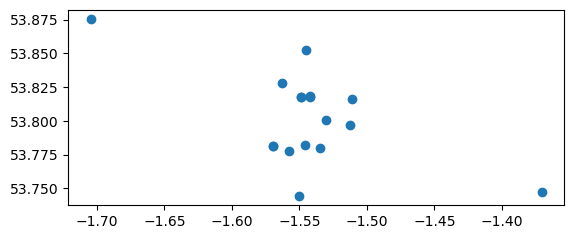

In [162]:
charity_all_2023.plot()

In [192]:
#generate h3 hexagons using Tobler's h3fy function
leeds_hex = h3fy(leeds_bua, resolution=9, buffer=True, clip=True) #set resolution and Clip=False to ensure all hexagons are within the boundaries of the municipalities
leeds_hex = leeds_hex.to_crs(leeds_bua.crs)
leeds_hex.insert(0, 'id', range(1, 1 + len(leeds_hex)))

leeds_hex.head()

id                                           geometry
hex_id                                                                
8919421852bffff   1  MULTIPOLYGON (((-1.55572 53.70262, -1.55577 53...
89194218523ffff   2  POLYGON ((-1.55592 53.70330, -1.55576 53.70330...
89194218593ffff   3  MULTIPOLYGON (((-1.54880 53.72103, -1.54878 53...
8919421a367ffff   4  POLYGON ((-1.54880 53.72103, -1.54882 53.72102...
8919421a36bffff   5  MULTIPOLYGON (((-1.56220 53.72477, -1.56002 53...

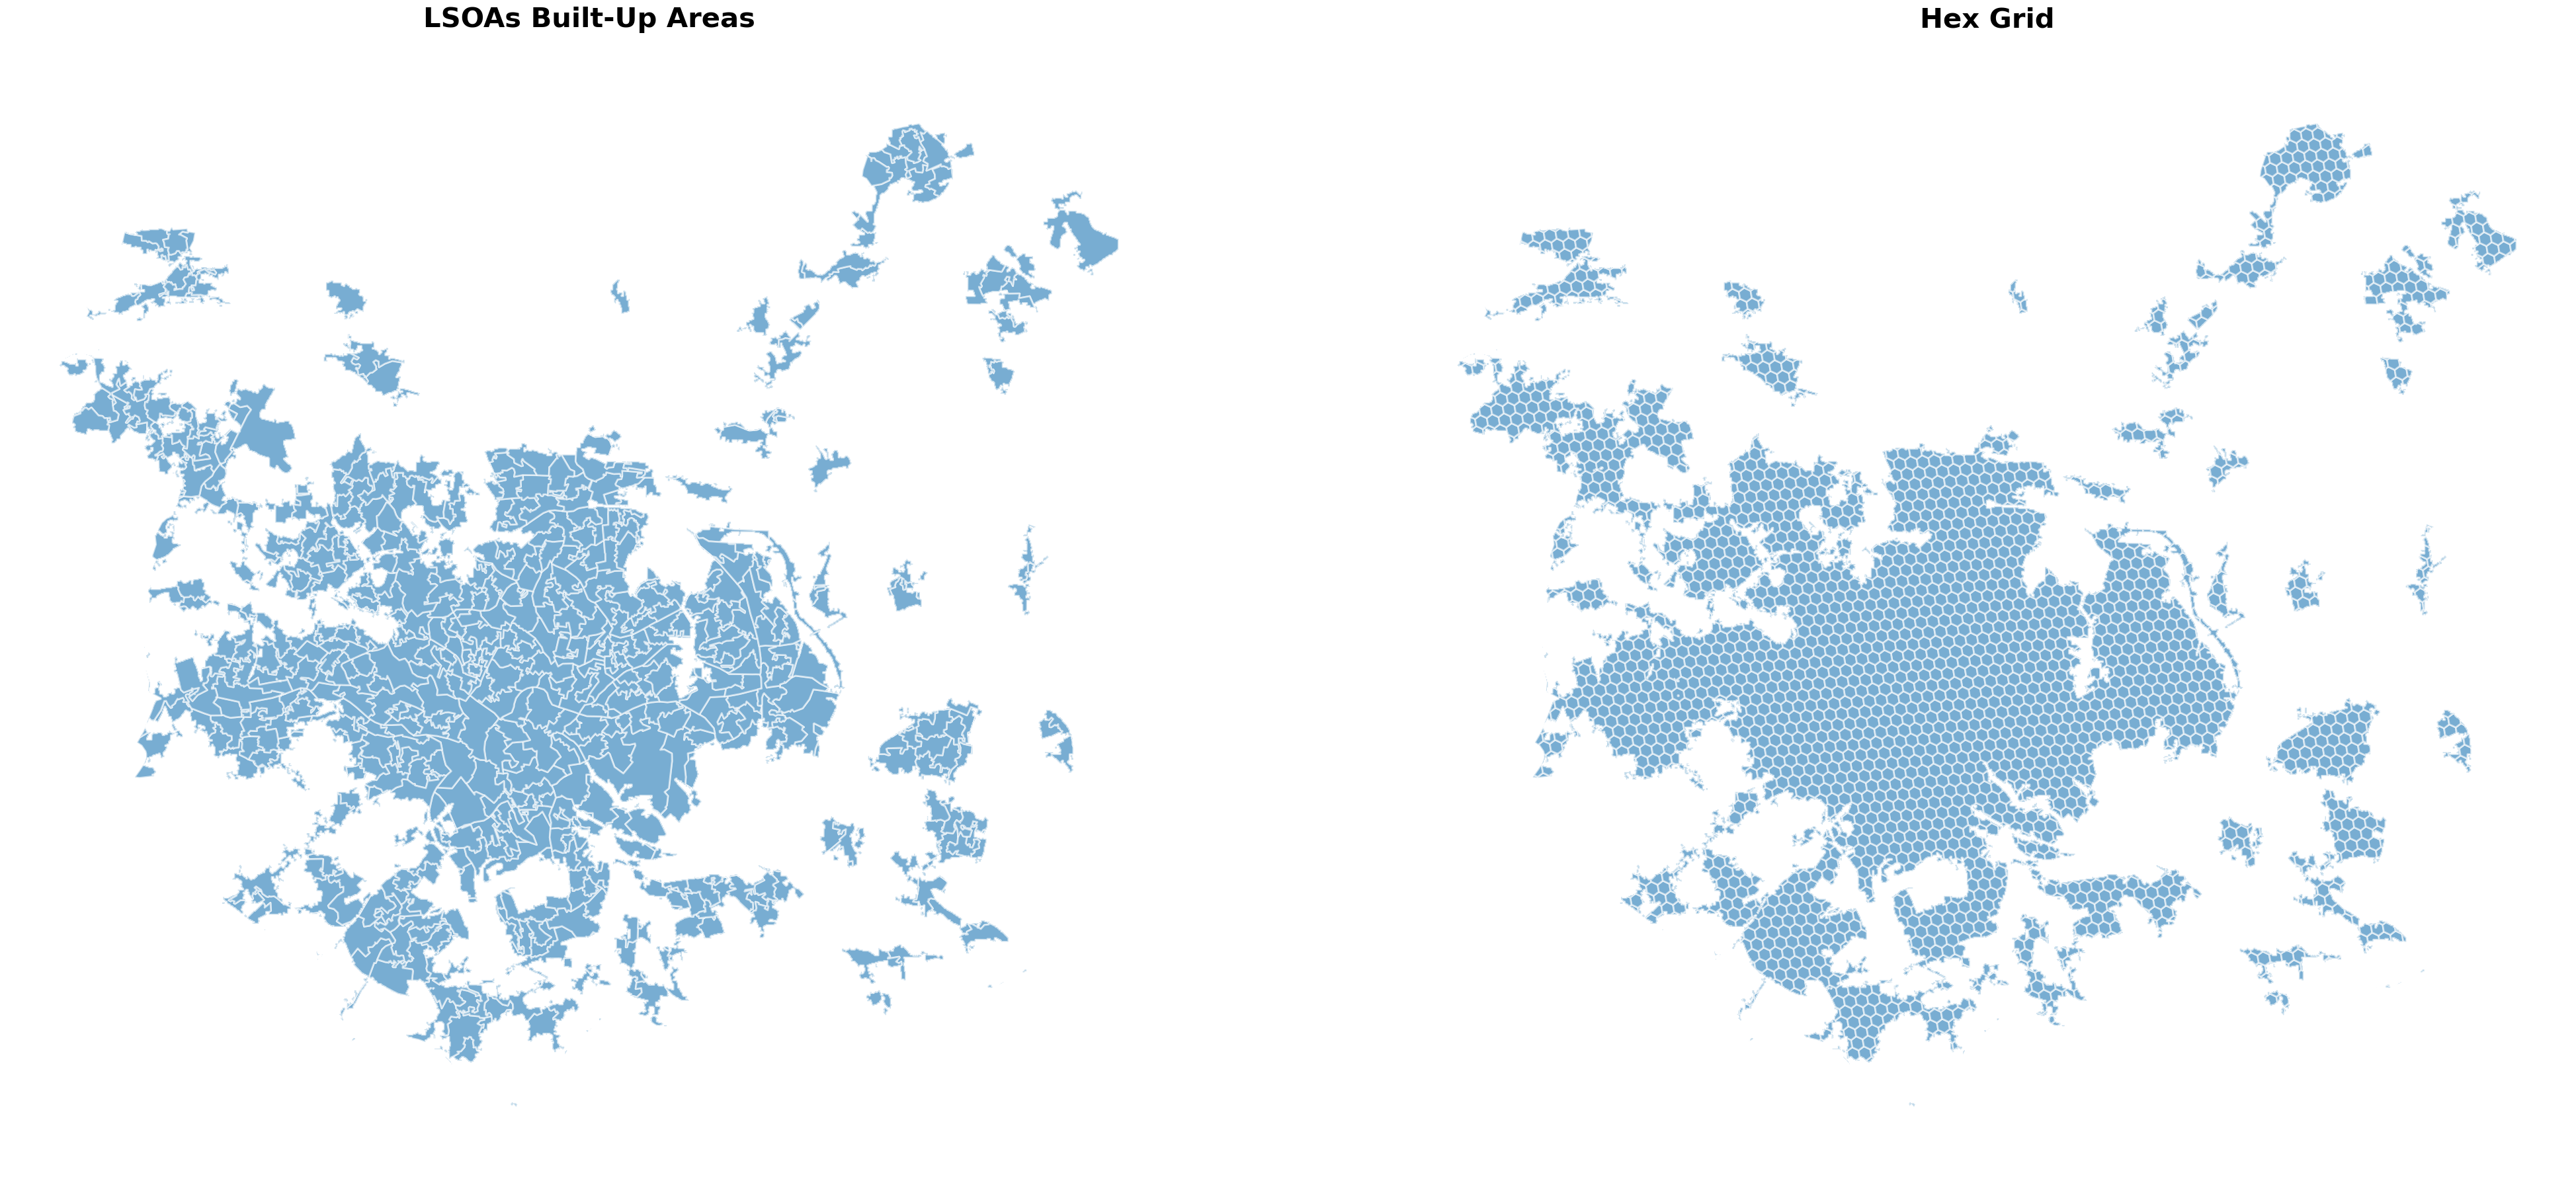

In [193]:
fig, axs = plt.subplots(1,2, figsize=(50,50), )
axs=axs.flatten()

leeds_bua.plot(ax=axs[0], alpha=0.6, linewidth=2, edgecolor='white')
leeds_hex.plot(ax=axs[1], alpha=0.6, linewidth=2, edgecolor='white')

axs[0].set_title('LSOAs Built-Up Areas', fontweight="bold", size=30)
axs[1].set_title('Hex Grid', fontweight="bold", size=30)

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_box_aspect(1)
axs[1].set_box_aspect(1)


In [194]:
#Interpolate total population and under-19 population for h3 hexagons
leeds_hex = area_interpolate(source_df=leeds_bua, target_df=leeds_hex, extensive_variables=['Age: Total', 'pop_under19'])
#add an id column with simple series of ids to the interpolated hexgrid layer
leeds_hex.insert(0, 'id', range(1, 1 + len(leeds_hex)))
leeds_hex.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3151 entries, 0 to 3150
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           3151 non-null   int64   
 1   Age: Total   3151 non-null   float64 
 2   pop_under19  3151 non-null   float64 
 3   geometry     3151 non-null   geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 98.6 KB


Text(0.5, 0.98, 'Spatial Interpolation of under-19 population on hexgrid level')

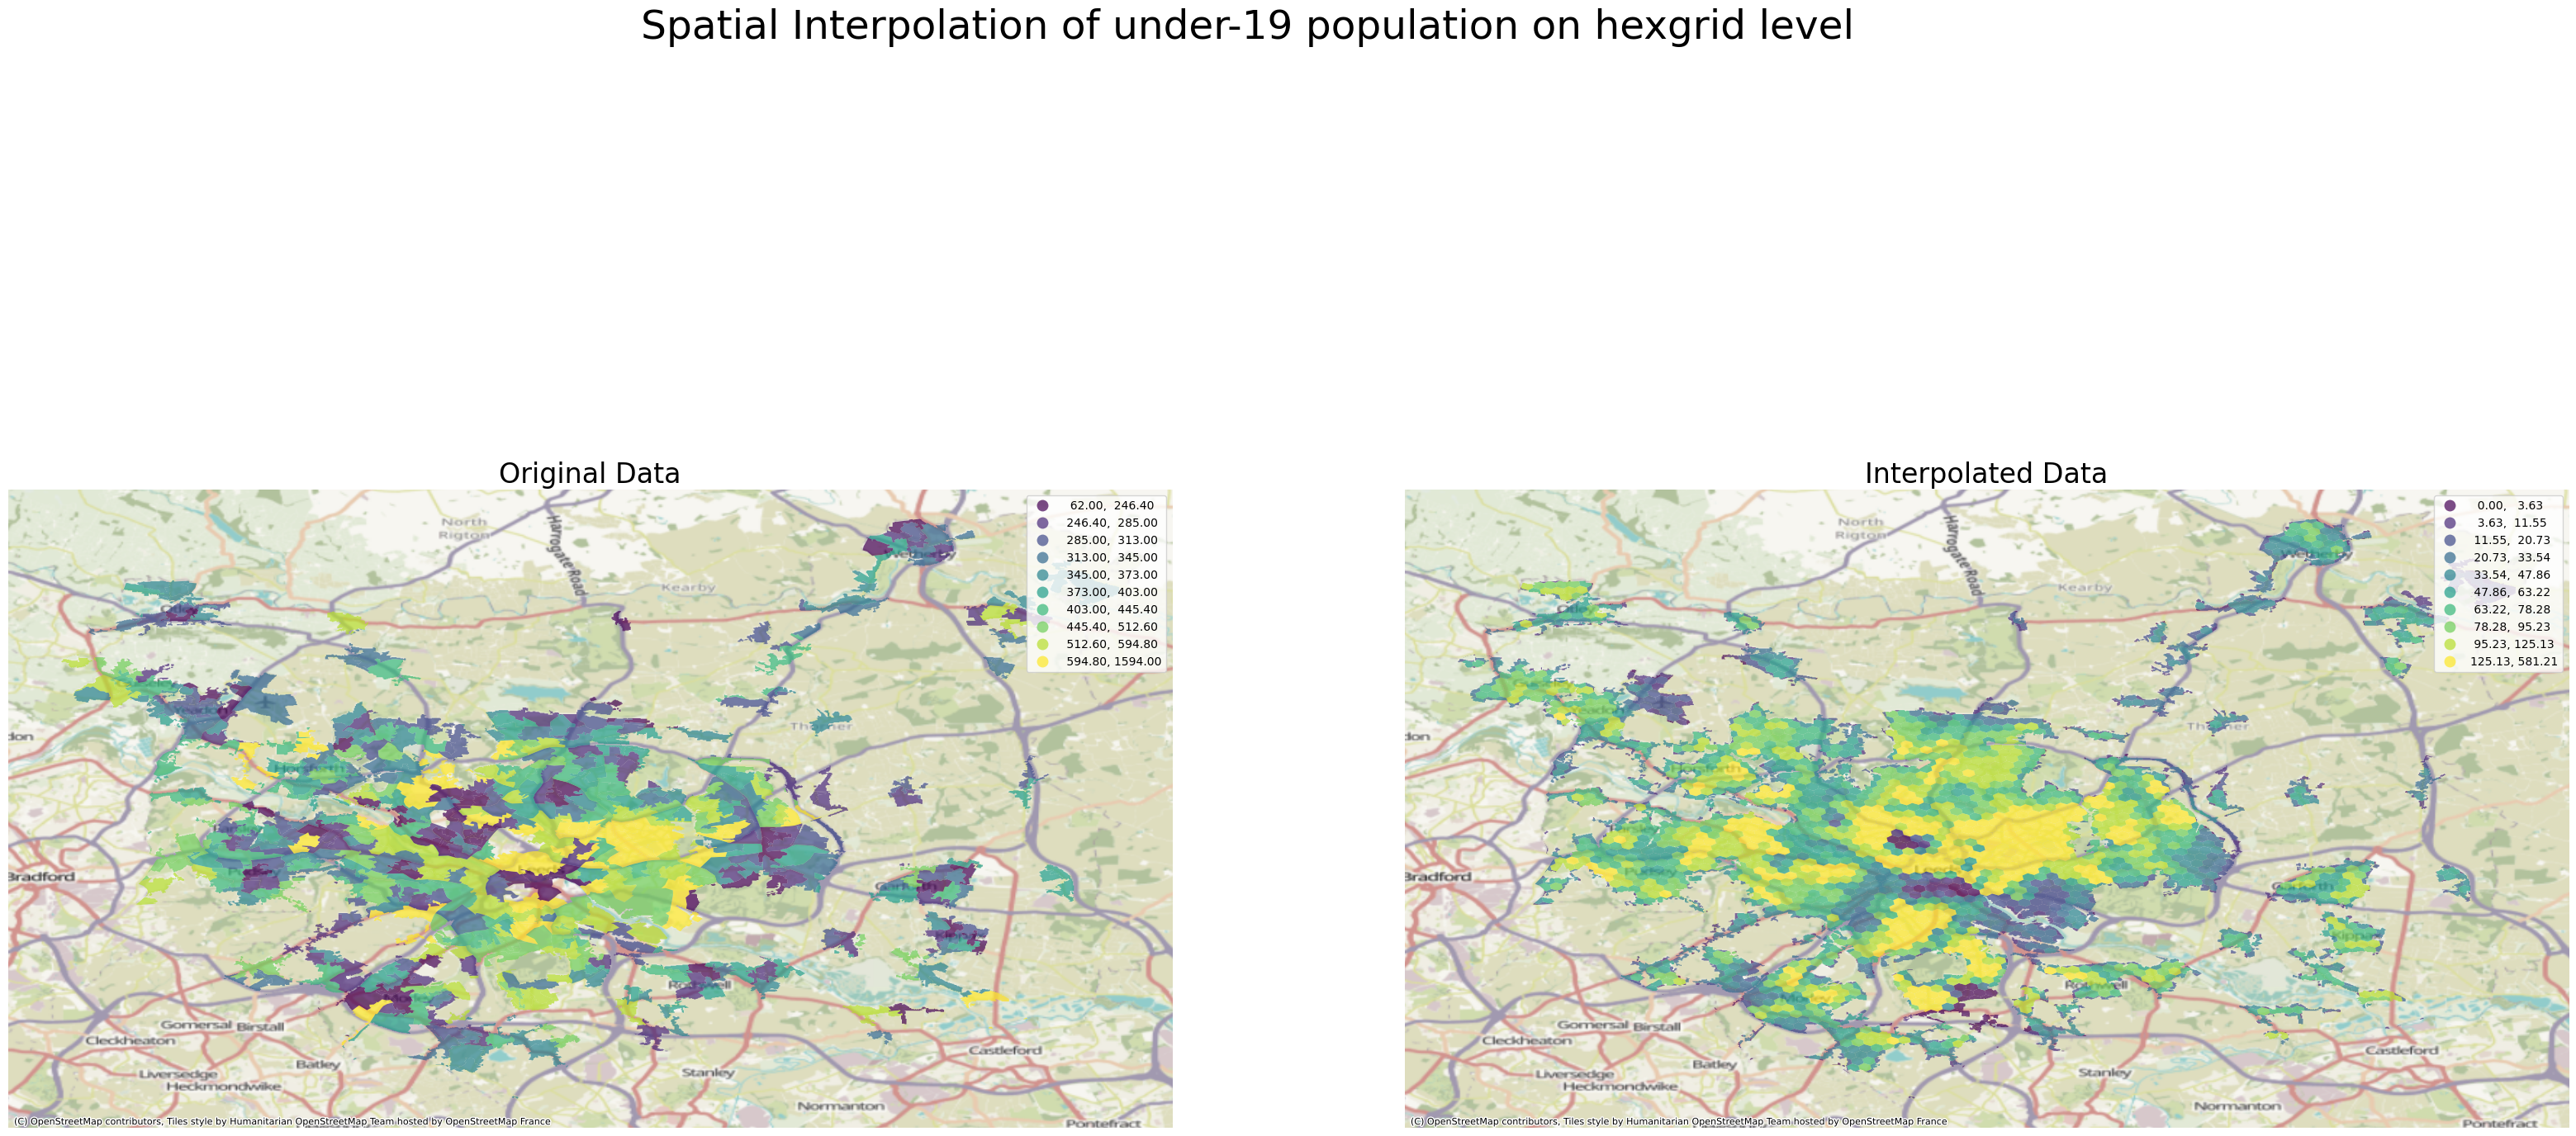

In [195]:
fig, axs = plt.subplots(1,2, figsize=(40,20))
leeds_bua.plot('pop_under19', scheme='quantiles', cmap='viridis', k = 10, legend = True, alpha=0.7, ax=axs[0])

leeds_hex.plot('pop_under19', scheme='quantiles', cmap='viridis', k = 10, legend = True, alpha=0.7, ax=axs[1])

axs[0].set_title('Original Data',fontsize=24)
axs[1].set_title('Interpolated Data',fontsize=24)

for ax in axs:
    ctx.add_basemap(ax=ax, crs=leeds_bua.crs, source=ctx.providers.OpenStreetMap.HOT)
    ax.axis('off')
plt.suptitle('Spatial Interpolation of under-19 population on hexgrid level', fontsize=35)

In [184]:
leeds_bua.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   FID             482 non-null    int64   
 1   lsoa11cd        482 non-null    object  
 2   lsoa11nm        482 non-null    object  
 3   IMDRank         482 non-null    int64   
 4   IMDDecil        482 non-null    int64   
 5   Shape__Area     482 non-null    float64 
 6   Shape__Length   482 non-null    float64 
 7   geometry        482 non-null    geometry
 8   temp            482 non-null    int64   
 9   geography code  473 non-null    object  
 10  Age: Total      473 non-null    float64 
 11  pop_under19     473 non-null    float64 
dtypes: float64(4), geometry(1), int64(4), object(3)
memory usage: 45.3+ KB


In [185]:
leeds_lsoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 482 entries, 10324 to 32857
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   FID            482 non-null    int64   
 1   lsoa11cd       482 non-null    object  
 2   lsoa11nm       482 non-null    object  
 3   IMDRank        482 non-null    int64   
 4   IMDDecil       482 non-null    int64   
 5   Shape__Area    482 non-null    float64 
 6   Shape__Length  482 non-null    float64 
 7   geometry       482 non-null    geometry
dtypes: float64(2), geometry(1), int64(3), object(2)
memory usage: 33.9+ KB


In [167]:
#generate centroids for all hexagons
leeds_hex["centroid"] = leeds_hex["geometry"].centroid

In [168]:
points = leeds_hex.drop(['geometry'], axis=1)
points = points.rename(columns={"centroid": "geometry", "hex_id":"id"}).to_crs(4326)
points.head()

id  Age: Total  pop_under19                   geometry
0   1   85.733361    21.723336  POINT (-1.70291 53.84273)
1   2  254.189287    59.260007  POINT (-1.60568 53.83940)
2   3   16.130050     3.689320  POINT (-1.59200 53.71729)
3   4    0.000000     0.000000  POINT (-1.71199 53.79006)
4   5  129.245234    26.197047  POINT (-1.44065 53.83122)

### Travel time computation

In [169]:
charity_all_2023.insert(0, 'id', range(1, 1 + len(charity_all_2023)))
charity_all_2023.head()

id Nature of Organisation    Beneficiary Group  \
2    1                 School  Children (Under 18)   
5    2                 School  Children (Under 18)   
8    3      Food service only  Children (Under 18)   
13   4       Community centre  Children (Under 18)   
14   5       Community centre  Children (Under 18)   

                            Charity  Food Moved KG  \
2   Allerton Bywater Primary School        1835.20   
5           Allerton C of E Primary        2200.96   
8     Catch/Ark Community Cafe (HH)         193.50   
13                   CFYDC (Chance)        2344.20   
14                   CFYDC (Chance)         833.00   

    Food Moved Meal Equivalents  CFMs Served  CFM Beneficiaries Value of food  \
2                    4369.61120          1.0              115.0      6,295.28   
5                    5240.48576          1.0              115.0      8,059.38   
8                     460.72350          1.0              115.0        599.48   
13                   5581.54020          1.0              115.0      9,834.87   
14                   1983.37300          1.0              115.0      2,521.88   

      Year      long        lat                Coordinates  
2   2024.0 -1.370255  53.747328  POINT (-1.37026 53.74733)  
5   2024.0 -1.545439  53.852317  POINT (-1.54544 53.85232)  
8   2024.0 -1.511364  53.816355  POINT (-1.51136 53.81635)  
13  2024.0 -1.542289  53.818422  POINT (-1.54229 53.81842)  
14  2024.0 -1.542422  53.817986  POINT (-1.54242 53.81799)

<Axes: >

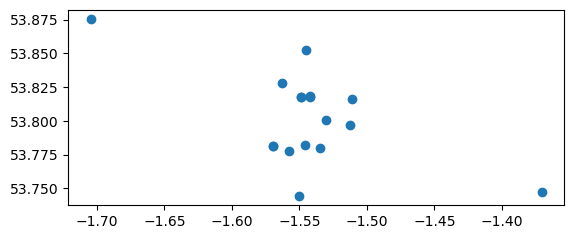

In [170]:
#create a subset of food charities for travel time calculation
destinations = charity_all_2023[['id','Coordinates']]
destinations.plot()

In [171]:
import sys
sys.argv.append(["--max-memory", "12G"]) #override ram limitation for r5py computations
import r5py
from r5py import TransportNetwork

In [172]:
#adding OSM road network and GTFS feed to the transport network variable
road_netowrk = 'Leeds._roads.osm.pbf'
transport_network = TransportNetwork(road_netowrk,)

In [173]:
import datetime
from r5py import TravelTimeMatrixComputer, TransitMode, LegMode

travel_time_matrix_computer = TravelTimeMatrixComputer(
    transport_network,
    origins = points,
    destinations=destinations,
    departure=datetime.datetime(2024, 5, 16, 8, 30),
    transport_modes=[LegMode.WALK]
)
access_t = travel_time_matrix_computer.compute_travel_times()

access_t = access_t.dropna() #drop rows with NaN travel time
access_t.head()

from_id  to_id  travel_time
6        1      7         72.0
1        2      2         84.0
3        2      4         94.0
4        2      5         95.0
9        2     10         84.0

In [174]:
#remove all O-D pairs with trips of more than 30 minutes
accessible_destinations= access_t[access_t['travel_time'] <= 30]
accessible_destinations.head()

from_id  to_id  travel_time
8         9      9         20.0
15        9     16         30.0
5        18      6         19.0
16       28     17         15.0
11       29     12         27.0

In [175]:
food_quant = charity_all_2023[['id', 'Food Moved KG', 'Food Moved Meal Equivalents']]
food_quant = pd.merge(accessible_destinations, food_quant, left_on='to_id', right_on= 'id', how='left')
food_quant = food_quant[['from_id','Food Moved KG', 'Food Moved Meal Equivalents']]
food_quant = food_quant.groupby('from_id').agg({'Food Moved KG': 'sum', 'Food Moved Meal Equivalents': 'sum'})
food_quant

Food Moved KG  Food Moved Meal Equivalents
from_id                                            
9              2658.32                   6329.45992
18              760.90                   1811.70290
28              291.00                    692.87100
29             2279.52                   5427.53712
36              760.90                   1811.70290
...                ...                          ...
2943           1835.20                   4369.61120
2953           1835.20                   4369.61120
2957           1835.20                   4369.61120
2976           1835.20                   4369.61120
2977           1835.20                   4369.61120

[563 rows x 2 columns]

In [176]:
food_quant_hex = pd.merge(leeds_hex, food_quant, how='left', left_on =['id'], right_on=['from_id'])
food_quant_hex = food_quant_hex.drop(food_quant_hex[food_quant_hex['pop_under19'] == 0].index)
food_quant_hex = food_quant_hex.fillna(0)

food_quant_hex['meal_equ_capita_u19'] = food_quant_hex['Food Moved Meal Equivalents'] / food_quant_hex['pop_under19']
food_quant_hex['food_kg_capita_u19'] = food_quant_hex['Food Moved KG'] / food_quant_hex['pop_under19']

food_quant_hex.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3117 entries, 0 to 3167
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           3117 non-null   int64   
 1   Age: Total                   3117 non-null   float64 
 2   pop_under19                  3117 non-null   float64 
 3   geometry                     3117 non-null   geometry
 4   centroid                     3117 non-null   geometry
 5   Food Moved KG                3117 non-null   float64 
 6   Food Moved Meal Equivalents  3117 non-null   float64 
 7   meal_equ_capita_u19          3117 non-null   float64 
 8   food_kg_capita_u19           3117 non-null   float64 
dtypes: float64(6), geometry(2), int64(1)
memory usage: 243.5 KB


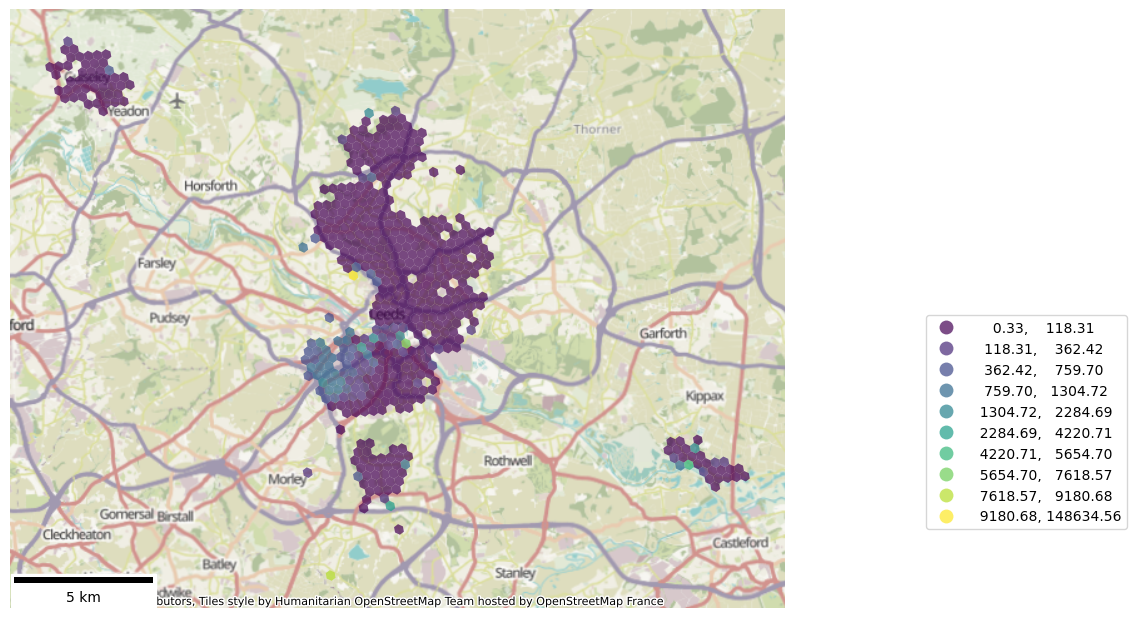

In [177]:
fig, ax = plt.subplots(1, figsize=(10,10))
food_quant_hex[food_quant_hex['food_kg_capita_u19'] > 0].to_crs(27700).plot(ax = ax,column = 'food_kg_capita_u19', scheme = 'natural_breaks', cmap = 'viridis', k = 10 ,legend = True, alpha = 0.7)
ctx.add_basemap(ax, crs = 27700 , source=ctx.providers.OpenStreetMap.HOT) 

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.45,0.5))
scale1 = ScaleBar(dx=1,location='lower left') #create a scale bar, with dx set to the number of pixels per unit, and 
ax.add_artist(scale1) #plot the scale bar


ax.set_axis_off()
plt.show()

In [178]:
food_quant_hex = food_quant_hex.drop(columns=['centroid']).to_crs(27700)
food_quant_hex.to_file('leeds_food_quant.geojson', driver="GeoJSON") 


In [179]:
leeds_bua.to_crs(27700).to_file('leeds_bua.geojson', driver="GeoJSON")

In [180]:
leeds_lsoa.to_crs(27700).to_file('leeds_lsoa.geojson', driver="GeoJSON")

In [181]:
charity_all_2023.set_crs(4326).to_crs(27700).to_file('leeds_charities_edited.geojson', driver="GeoJSON")

In [182]:
charity_all_original = pd.read_csv('Dispatch Metrics_Children_all_Source.csv')
charity_all_original_2023 = charity_all_original[charity_all_original.Year == 2024]

from shapely.geometry import Point
charity_all_original_2023['Coordinates'] = list(zip(charity_all_original_2023.long, charity_all_original_2023.lat))
charity_all_original_2023['Coordinates'] = charity_all_original_2023['Coordinates'].apply(Point)
charity_all_original_2023 = gpd.GeoDataFrame(charity_all_original_2023, geometry='Coordinates')
charity_all_original_2023.head()
charity_all_original_2023.set_crs(4326).to_crs(27700).to_file('leeds_charities_FS.geojson', driver="GeoJSON")
                                
